In [210]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
import os
os.chdir('/content/drive/MyDrive/GSS16')

In [212]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, gamma, poisson

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.gam.api import GLMGam, BSplines

from statsmodels.tools.eval_measures import rmse, mse

from zmq.constants import NULL

import warnings
warnings.filterwarnings('ignore')

In [213]:
gss16 = pd.read_csv('gss16.csv')
gss16

,harass5,emailmin,emailhr,educ,polviews,advfront,snapchat,instagrm,wrkstat
0,NaN,0.0,12.0,16.0,Moderate,Strongly agree,NaN,NaN,Working fulltime
1,NaN,30.0,0.0,12.0,Liberal,Disagree,No,No,Working fulltime
2,No,NaN,NaN,16.0,Conservative,NaN,No,No,Retired
3,NaN,10.0,0.0,12.0,Moderate,Disagree,NaN,NaN,Working parttime
4,No,NaN,NaN,18.0,Slightly liberal,NaN,Yes,Yes,Working parttime
...,...,...,...,...,...,...,...,...,...
2862,NaN,0.0,20.0,20.0,Extremely liberal,Agree,No,Yes,Working fulltime
2863,NaN,0.0,2.0,15.0,Conservative,Disagree,NaN,NaN,Working fulltime
2864,No,0.0,0.0,14.0,Moderate,NaN,NaN,NaN,Keeping house
2865,NaN,0.0,1.0,14.0,Slghtly conservative,Agree,NaN,NaN,Working fulltime


# 1. Tiền xử lý dữ liệu và thống kê mô tả

Loại bỏ các row có trường nhãn (thời gian dùng email bị null)

In [214]:
dat = gss16[(gss16['emailmin'].notna())&(gss16['emailhr'].notna())]

Tạo cột tổng thời gian dùng email từ 2 cột về số giờ, số phút dùng email.

In [215]:
dat["emailmintotal"] = dat["emailmin"] + dat["emailhr"]*60
# dat.drop(["emailhr", "emailmin"], axis=1, inplace= True)

Scale trường emailmintotal, educ về khoảng [0, 1].

Vì ta sẽ muốn dùng phân phối họ mũ cho dữ liệu liên tục dương, trong khi dữ liệu có những mẫu emailmintotal=0, nên ta cộng 1 hằng số dương vào giá trị của emailmintotal sau khi scale.

In [216]:
min_time=dat["emailmintotal"].min()
max_time=dat["emailmintotal"].max()
dat["emailmintotal_center"] = [(x-min_time)/(max_time-min_time)+0.001 for x in dat["emailmintotal"]]

# dat["emailmintotal_center"] = dat["emailmintotal"] + 1

min_educ=dat["educ"].min()
max_educ=dat["educ"].max()
dat["educ_center"] = [(x-min_educ)/(max_educ-min_educ) for x in dat["educ"]]

# dat["educ_center"] = dat['educ']
# dat.drop(["emailmintotal", "educ"], axis=1, inplace= True)

In [217]:
dat.shape

(1649, 12)

In [218]:
dat.describe()

,emailmin,emailhr,educ,emailmintotal,emailmintotal_center,educ_center
count,1649.000000,1649.000000,1648.000000,1649.000000,1649.000000,1648.000000
mean,3.318981,6.892056,14.037621,416.842329,0.070474,0.668757
std,9.263936,11.366222,2.722956,680.148486,0.113358,0.151275
min,0.000000,0.000000,2.000000,0.000000,0.001000,0.000000
25%,0.000000,0.000000,12.000000,50.000000,0.009333,0.555556
50%,0.000000,2.000000,14.000000,120.000000,0.021000,0.666667
75%,0.000000,8.000000,16.000000,480.000000,0.081000,0.777778
max,59.000000,100.000000,20.000000,6000.000000,1.001000,1.000000


Như vậy, dữ liệu giờ chỉ còn 2 cột dữ liệu dạng số. Các cột còn lại là loại categorical. Ta kiểm tra số giá trị null tại mỗi cột và thống kê số lượng các giá trị khác null.

In [219]:
for col in dat.columns:
    if col in ["harass5", "polviews", "advfront", "snapchat", "instagrm", "wrkstat"]:
        print("field: ", col)
        print('- number of NaN value: {0:2d} ({1:.2f}%)'.format(dat[col].isna().sum(), dat[col].isna().sum()/1649))
        print('- values:')
        print(dat[col].value_counts())
        print('\n')
    elif col == "educ_center":
        print("field: ", col)
        print('- number of NaN value:', dat[col].isna().sum())
        print('\n')

field:  harass5
- number of NaN value: 1218 (0.74%)
- values:
No                                                         350
Yes                                                         62
Does not apply (i do not have a job/superior/co-worker)     19
Name: harass5, dtype: int64


field:  polviews
- number of NaN value: 55 (0.03%)
- values:
Moderate                595
Conservative            239
Slghtly conservative    228
Liberal                 212
Slightly liberal        180
Extremely liberal        81
Extrmly conservative     59
Name: polviews, dtype: int64


field:  advfront
- number of NaN value: 433 (0.26%)
- values:
Agree                673
Strongly agree       367
Disagree             152
Dont know             13
Strongly disagree     11
Name: advfront, dtype: int64


field:  snapchat
- number of NaN value: 969 (0.59%)
- values:
No     516
Yes    164
Name: snapchat, dtype: int64


field:  instagrm
- number of NaN value: 969 (0.59%)
- values:
No     457
Yes    223
Name: instagrm

Như vậy, 1 số cột categorical có tỷ lệ null khá nhiều (harass5 có 3/4 giá trị null, advfront có 1/4 số dòng null, snapchat và instagrm có gần 60% số dòng null). Vì vậy, với các cột categorical, ta mã hóa các giá trị null thành 1 nhóm riêng.

Cột dữ liệu số có 1 mẫu educ bị null. Vì số lượng nhỏ nên ta loại bỏ mẫu này.

In [220]:
dat = dat[dat['educ_center'].notna()]

dat.fillna("Not give", inplace=True)

In [221]:
dat.replace("Does not apply (i do not have a job/superior/co-worker)", "Does not apply", inplace=True)

**1.a. Kiểm tra phân phối của biến phụ thuôc**

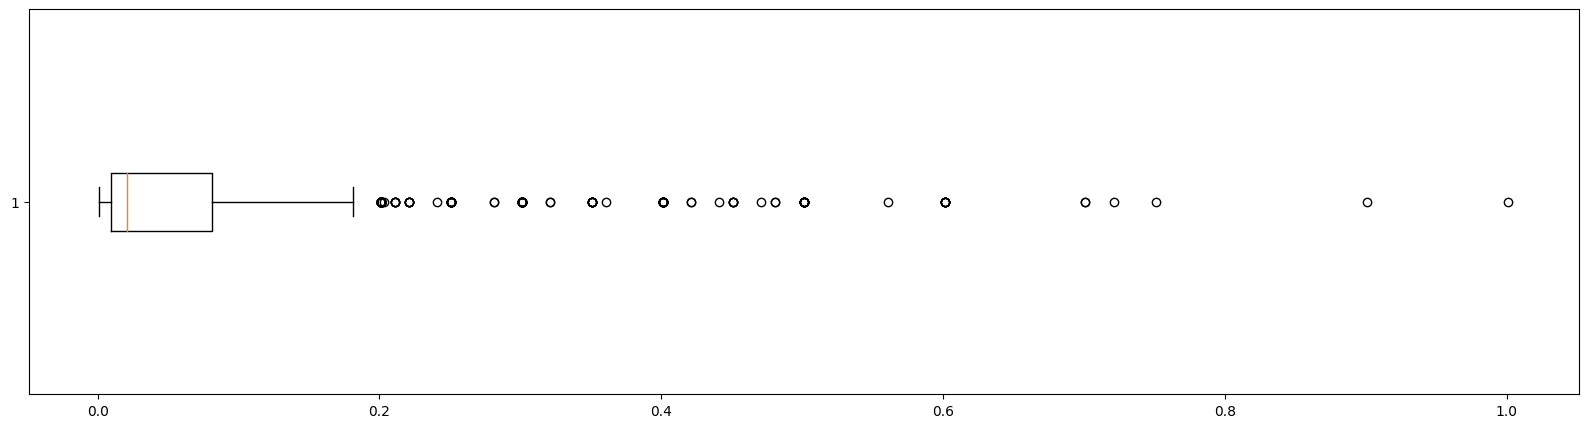

In [222]:
plt.figure(figsize=(20, 5))
plt.boxplot(dat['emailmintotal_center'], vert=False)
plt.show()

Có thể thấy dữ liệu emailmintotal rất phân tán, giá trị trong khoảng [0, 6000]. Dữ liệu tập trung nhiều ở vùng giá trị thấp, hình ảnh right skewed rõ nét.

Ta xem thêm biểu đồ histogram về phân phối của dữ liệu:

(0.0, 100.0)

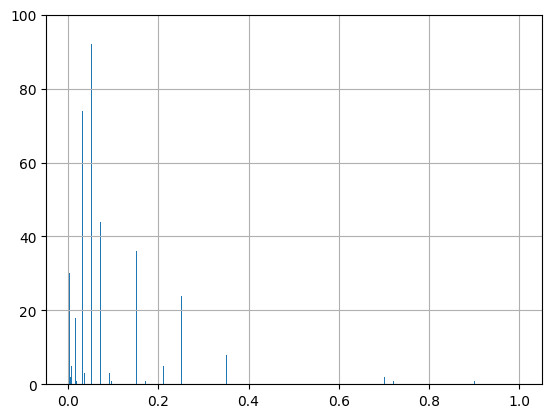

In [223]:
dat['emailmintotal_center'].hist(bins = 1300)
plt.ylim([0,100])

Có thể thấy, emailmintotal là biến liên tục không âm, gợi ý về phân phối Gamma (ta có thể cộng thêm 1 hằng số dương để đảm bảo giá trị luôn dương). Và với biểu đồ histogram phía trên cũng có hình ảnh phân phối Gamma.

Ta sẽ dùng biểu đồ QQplot để kiểm tra thêm việc này.

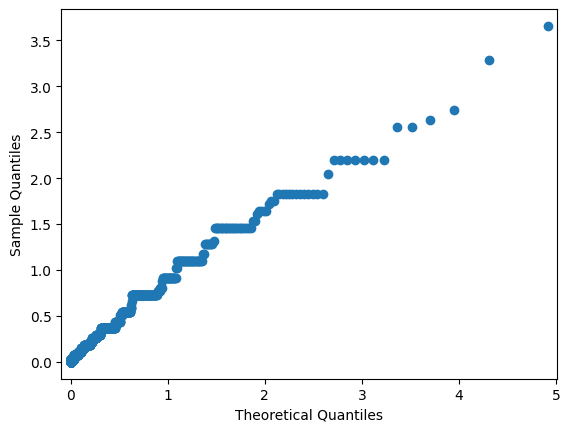

In [224]:
qqplot(dat["emailmintotal_center"],gamma,fit=True)
plt.show()

Như vậy, emailmintotal khá khớp với phân phối **Gamma**

**1.b. Xem xét sự phụ thuộc của biến đầu ra so với các biến giải thích**

Xem xét emailmintotal đối với các cột categorical

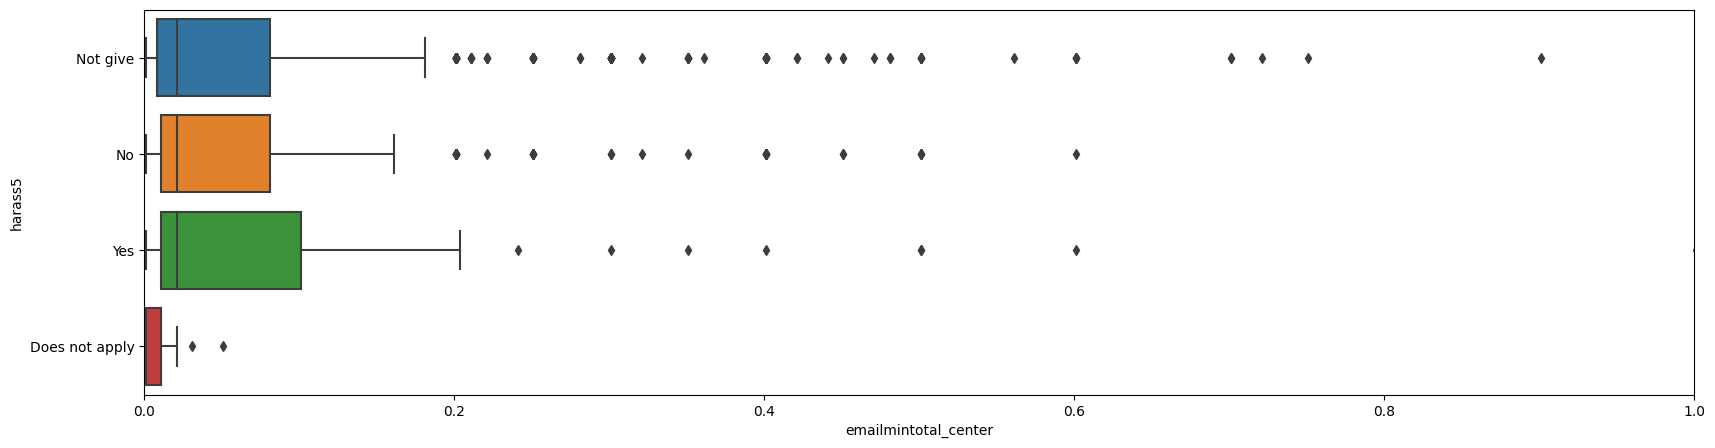

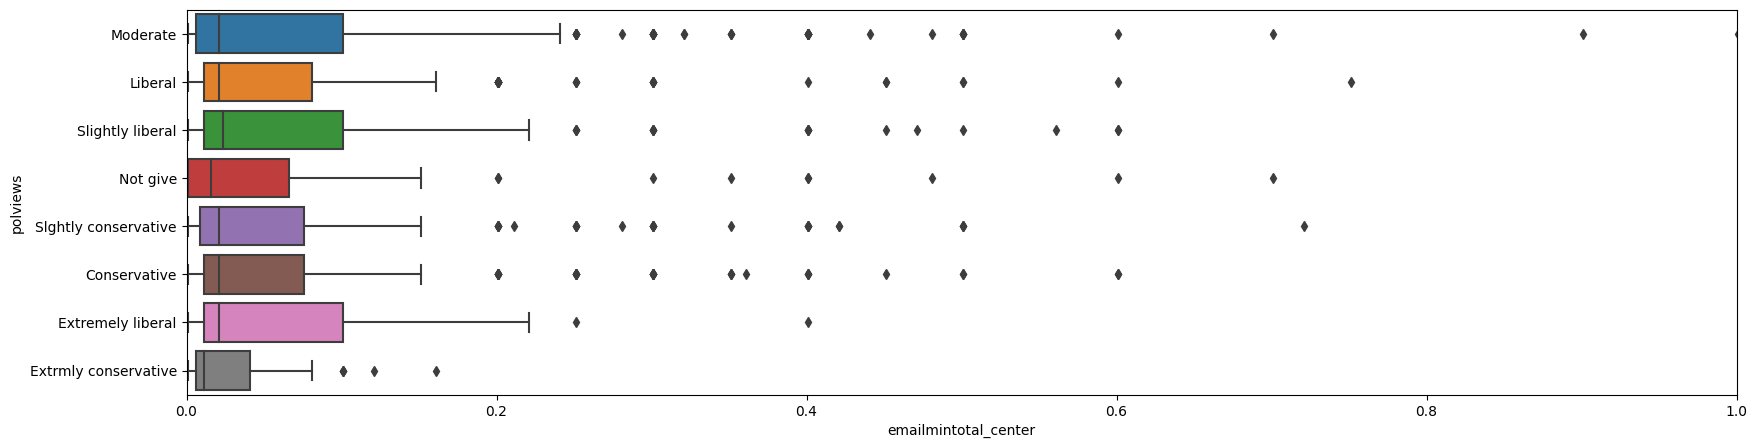

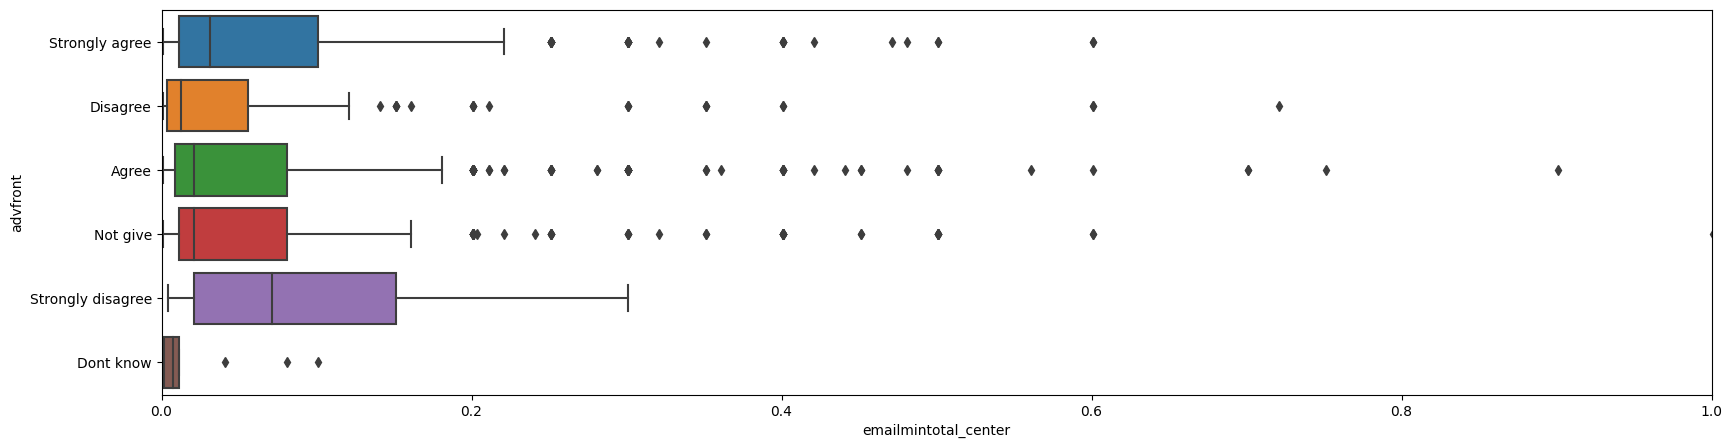

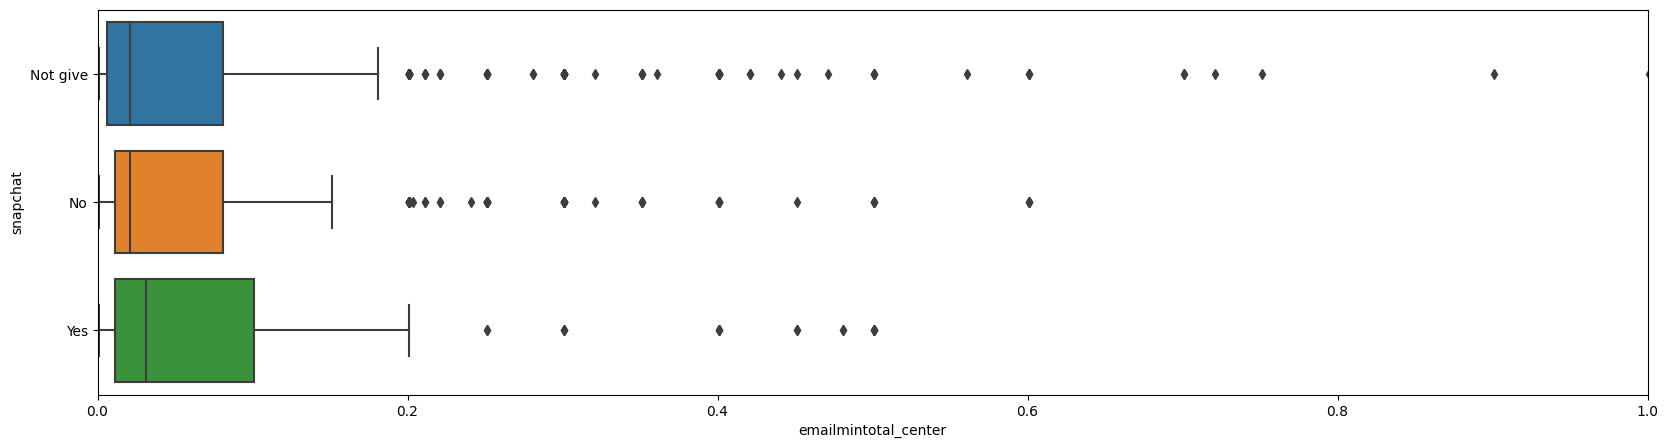

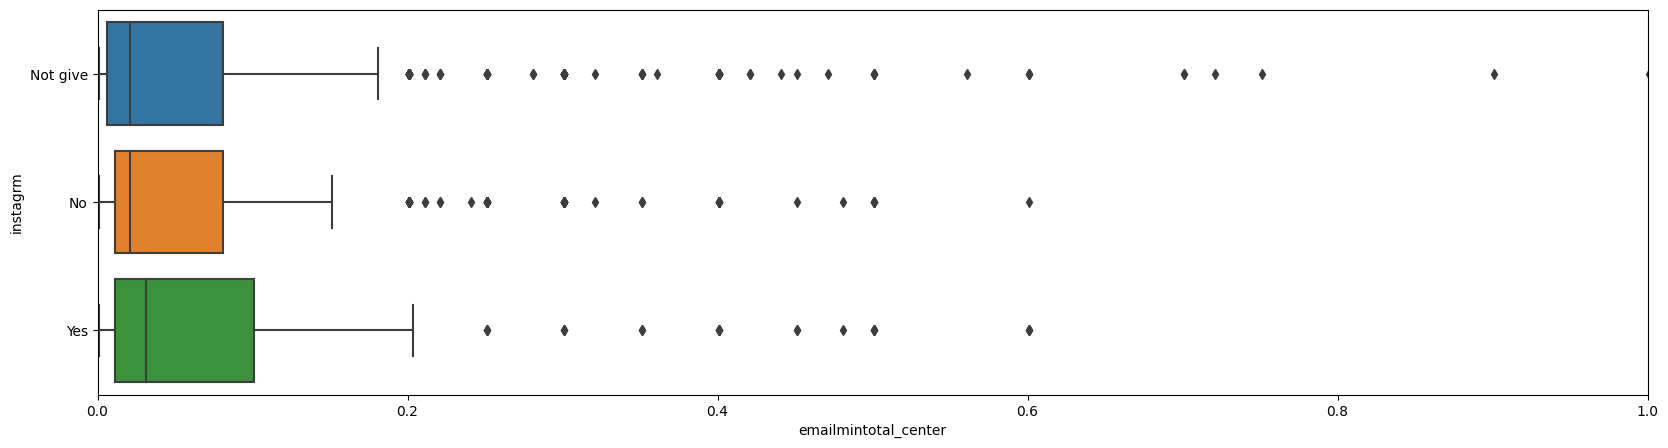

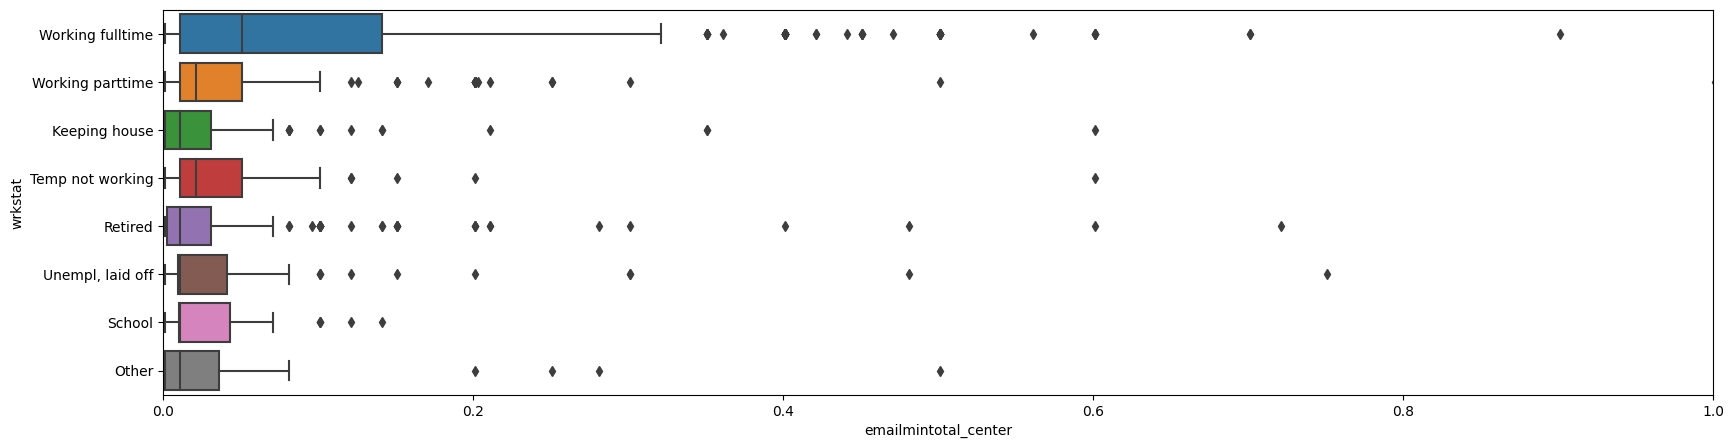

In [225]:
import seaborn as sns

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="harass5")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="polviews")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="advfront")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="snapchat")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="instagrm")
plt.xlim([0, 1])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal_center", y="wrkstat")
plt.xlim([0, 1])
plt.show()

Nhận xét:
- **harass**: nhóm không đi làm ít dùng email hơn 3 nhóm còn lại.
- **polviews**: nhóm Extrmly conservative dùng email ít hơn các nhóm còn lại.
- **advfront**: nhóm Strong disagree dùng nhiều email hơn hẳn các nhóm còn lại, sau đó tới nhóm Strong agree. Nhóm Dont know là dùng email ít nhất.
- **snapchat, instagrm**:  Nhân tố Snapchat và nhân tố Instagram có phân bố như nhau trên cả 3 giá trị (Dont know, No, Yes). Trong đó nhóm Yes dùng email nhiều hơn 2 nhóm còn lại, nghĩa là người dùng mạng xã hội có xu hướng dùng email nhiều hơn.
- **wrkstat**: nhóm "working fulltime" dùng email nhiều hơn hẳn các nhóm còn lại. Các nhóm không đi làm (Keeping house, Retired, Unempl/laid off, School, Other) có mức dùng email ít nhất. Các nhóm làm bán thời gian (working parttime, temp not working) có mức dùng email ở giữa nhóm đi làm và nhóm không đi làm.

Bản thân trong mỗi nhóm, số lượng outlier vẫn khá nhiều (dữ liệu khá phân tán).

Tiếp theo, xem xét sự phụ thuộc của emailmintotal đối với biến educ (biến dạng số duy nhất ở đây)

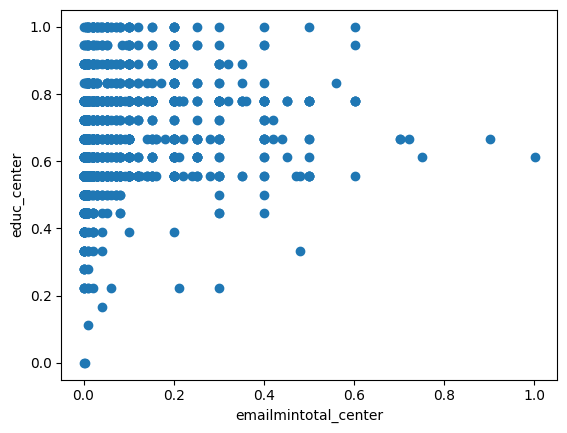

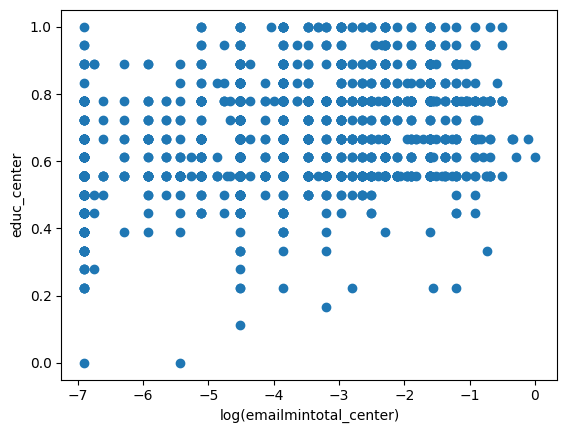

In [226]:
plt.scatter(dat["emailmintotal_center"], dat["educ_center"])
plt.xlabel("emailmintotal_center")
plt.ylabel("educ_center")
plt.show()

plt.scatter(np.log(dat["emailmintotal_center"]), dat["educ_center"])
plt.xlabel("log(emailmintotal_center)")
plt.ylabel("educ_center")
plt.show()


Biểu đồ scatter giữa educ và emailmintotal chưa thấy rõ được quan hệ tuyến tính giữa 2 biến này.

Ta chuyển scale cho emailmintotal bằng hàm log và kiểm tra lại. Ta thấy educ so với log(emailmintotal) có quan hệ có vẻ tuyến tính hơn, mặc dù độ phân tán khá lớn. Điều này gợi ý ta dùng **link function là hàm log**.

Vì sự quan hệ tuyến tính giữa educ và log(emailmintotal) không thể hiện sắc nét nên có thể giữa 2 biến này có quan hệ phi tuyến. Vì vậy, bên cạnh mô hình GLM, chúng em sẽ thử nghiệm thêm mô hình GAM để giải quyết vấn đề này.

Trong phần tiếp theo ta sẽ lựa chọn và xây dựng mô hình để dự đoán cho emailmintotal. **2 mô hình được lựa chọn thử nghiệm là GLM (Generalized Linear Model) và GAM (Generalized Additive Model).**

Trước tiên, ta tạm chia tập train/test theo tỷ lệ 80:20:

In [227]:
X = dat[["wrkstat", "educ_center", "polviews", "advfront", "harass5", "snapchat", "instagrm"]]
y = dat[["emailmintotal_center"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dat_train = pd.concat([X_train, y_train], axis=1)
dat_test = pd.concat([X_test, y_test], axis=1)


# 2. Mô hình GLM

**2.a. Lựa chọn thuộc tính**

Sau đó ta thử cho tất cả các cột vào fit mô hình GLM xem kết quả như thế nào:

In [228]:
formula_str = 'emailmintotal_center ~ harass5 + educ_center + polviews + advfront + snapchat + instagrm + wrkstat'

fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
fitted_glm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1318
Model:                              GLM   Df Residuals:                     1291
Model Family:                     Gamma   Df Model:                           26
Link Function:                      Log   Scale:                          2.7937
Method:                            IRLS   Log-Likelihood:                 2467.1
Date:                  Mon, 14 Aug 2023   Deviance:                       2707.3
Time:                          18:15:49   Pearson chi2:                 3.64e+03
No. Iterations:                     100   Pseudo R-squ. (CS):             0.1149
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.4195      1.320     -2.590      0.010      -6.007      -0.832
harass5[T.No]                        0.8663      0.468      1.852      0.064      -0.051       1.783
harass5[T.Not give]                 -1.3861      1.274     -1.088      0.277      -3.883       1.111
harass5[T.Yes]                       1.1776      0.523      2.253      0.024       0.153       2.202
polviews[T.Extremely liberal]       -0.1261      0.241     -0.523      0.601      -0.599       0.347
polviews[T.Extrmly conservative]    -0.4623      0.270     -1.712      0.087      -0.992       0.067
polviews[T.Liberal]                 -0.1496      0.178     -0.840      0.401      -0.499       0.200
polviews[T.Moderate]                 0.0409      0.146      0.280      0.779      -0.245       0.327
polviews[T.Not give]                 0.6025      0.283      2.129      0.033       0.048       1.157
polviews[T.Slghtly conservative]    -0.0931      0.175     -0.532      0.595      -0.436       0.250
polviews[T.Slightly liberal]         0.0754      0.187      0.403      0.687      -0.292       0.442
advfront[T.Disagree]                 0.1941      0.170      1.145      0.252      -0.138       0.526
advfront[T.Dont know]               -0.4455      0.495     -0.899      0.369      -1.416       0.526
advfront[T.Not give]                -2.4060      1.196     -2.012      0.044      -4.750      -0.063
advfront[T.Strongly agree]           0.0559      0.125      0.447      0.655      -0.189       0.301
advfront[T.Strongly disagree]        0.6680      0.511      1.307      0.191      -0.334       1.670
snapchat[T.Not give]                -0.0164      0.059     -0.277      0.782      -0.133       0.100
snapchat[T.Yes]                      0.3733      0.201      1.859      0.063      -0.020       0.767
instagrm[T.Not give]                -0.0164      0.059     -0.277      0.782      -0.133       0.100
instagrm[T.Yes]                     -0.0672      0.183     -0.368      0.713      -0.425       0.291
wrkstat[T.Other]                     0.5409      0.358      1.509      0.131      -0.162       1.243
wrkstat[T.Retired]                   0.2160      0.192      1.122      0.262      -0.161       0.593
wrkstat[T.School]                    0.0789      0.309      0.255      0.799      -0.527       0.685
wrkstat[T.Temp not working]          0.5817      0.340      1.711      0.087      -0.085       1.248
wrkstat[T.Unempl, laid off]          0.7409      0.281      2.641      0.008       0.191       1.291
wrkstat[T.Working fulltime]          1.1247      0.170      6.622      0.000       0.792       1.458
wrkstat[T.Working parttime]          0.4721      0.203      2.328      0.020       0.075       0.869
educ_center                    

Nhìn vào kết quả của mô hình sau khi fit, với mức ý nghĩa 5% thì thuộc tính snapchat và instagrm không ảnh hưởng đến mô hình.

Ta loại 2 thuộc tính này và fit lại mô hình thử xem

In [229]:
formula_str = 'emailmintotal_center ~ wrkstat + educ_center + polviews + advfront + harass5'

fitted_glm = NULL
fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1318
Model:                              GLM   Df Residuals:                     1294
Model Family:                     Gamma   Df Model:                           23
Link Function:                      Log   Scale:                          2.8721
Method:                            IRLS   Log-Likelihood:                 2453.3
Date:                  Mon, 14 Aug 2023   Deviance:                       2721.4
Time:                          18:15:49   Pearson chi2:                 3.72e+03
No. Iterations:                      22   Pseudo R-squ. (CS):             0.1086
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.3960      1.328     -2.558      0.011      -5.998      -0.794
wrkstat[T.Other]                     0.5240      0.363      1.443      0.149      -0.188       1.236
wrkstat[T.Retired]                   0.2237      0.194      1.155      0.248      -0.156       0.603
wrkstat[T.School]                    0.1583      0.309      0.512      0.608      -0.447       0.764
wrkstat[T.Temp not working]          0.6182      0.344      1.799      0.072      -0.055       1.292
wrkstat[T.Unempl, laid off]          0.8214      0.284      2.895      0.004       0.265       1.377
wrkstat[T.Working fulltime]          1.1450      0.172      6.661      0.000       0.808       1.482
wrkstat[T.Working parttime]          0.5045      0.205      2.460      0.014       0.103       0.906
polviews[T.Extremely liberal]       -0.1578      0.244     -0.647      0.517      -0.635       0.320
polviews[T.Extrmly conservative]    -0.4426      0.273     -1.619      0.105      -0.978       0.093
polviews[T.Liberal]                 -0.1742      0.180     -0.965      0.334      -0.528       0.179
polviews[T.Moderate]                 0.0650      0.148      0.441      0.660      -0.224       0.354
polviews[T.Not give]                 0.6195      0.286      2.163      0.031       0.058       1.181
polviews[T.Slghtly conservative]    -0.0793      0.177     -0.448      0.654      -0.427       0.268
polviews[T.Slightly liberal]         0.0712      0.189      0.376      0.707      -0.300       0.442
advfront[T.Disagree]                 0.1793      0.172      1.044      0.296      -0.157       0.516
advfront[T.Dont know]               -0.4557      0.502     -0.908      0.364      -1.439       0.527
advfront[T.Not give]                -2.4284      1.208     -2.010      0.044      -4.797      -0.060
advfront[T.Strongly agree]           0.0842      0.127      0.664      0.507      -0.164       0.333
advfront[T.Strongly disagree]        0.6731      0.518      1.300      0.194      -0.342       1.688
harass5[T.No]                        0.9551      0.472      2.022      0.043       0.029       1.881
harass5[T.Not give]                 -1.3951      1.290     -1.082      0.279      -3.922       1.132
harass5[T.Yes]                       1.2449      0.529      2.355      0.018       0.209       2.281
educ_center                          1.8066      0.326      5.543      0.000       1.168       2.445
====================================================================================================
"""

Nhận xét:

So với mô hình đầy đủ tất cả các feature ban đầu, mô hình phía trên có $R^2$ giảm không đáng kể nhưng mô hình đã đơn giản được 2 biến. Như vậy việc bỏ bớt feature không quan trọng của ta là đúng đắn.

Với mức ý nghĩa 5%, tất cả các feature giữ lại trong mô hình (wrkstat, educ, polviews, advfront, harass5) đều có ý nghĩa thống kê

**2.b. Diagnostic**

**Phần dư**

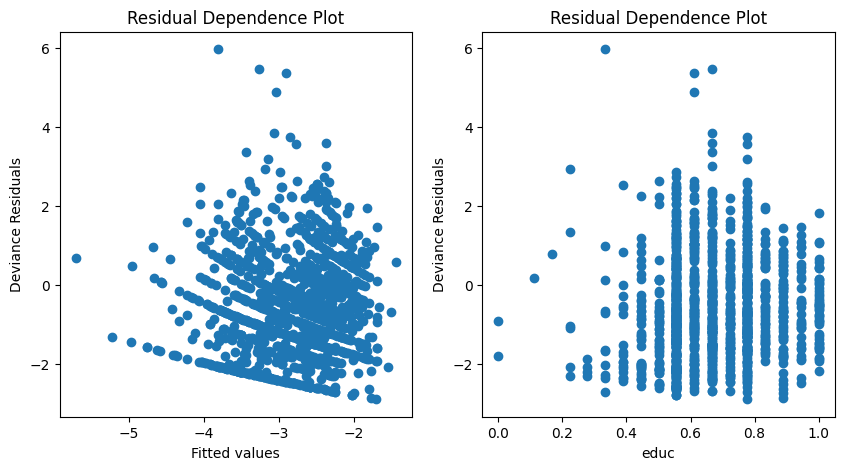

In [230]:
resid = fitted_glm.resid_deviance

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(np.log(fitted_glm.mu), resid)
# ax[0].hlines(0, 0, 1)
ax[0].set_title('Residual Dependence Plot')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_xlabel('Fitted values')

X_train = dat_train.drop(["emailmintotal_center"], axis=1)
ax[1].scatter(X_train['educ_center'], resid)
# ax[1].hlines(0, 0, 1)
ax[1].set_title('Residual Dependence Plot')
ax[1].set_ylabel('Deviance Residuals')
ax[1].set_xlabel('educ')
plt.show()

Nhận thấy, giá trị phần dư chuẩn hóa theo biến educ và fitted values có phân phối tương đối cân bằng xung quanh trục y=0.

Ta tiếp tục kiểm tra phân phối chuẩn của phần dư bằng biểu đồ QQplot

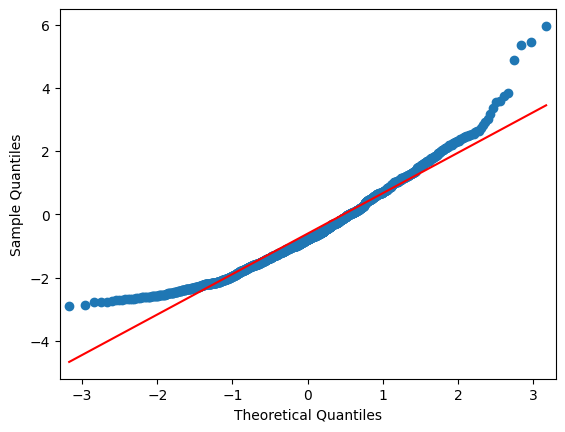

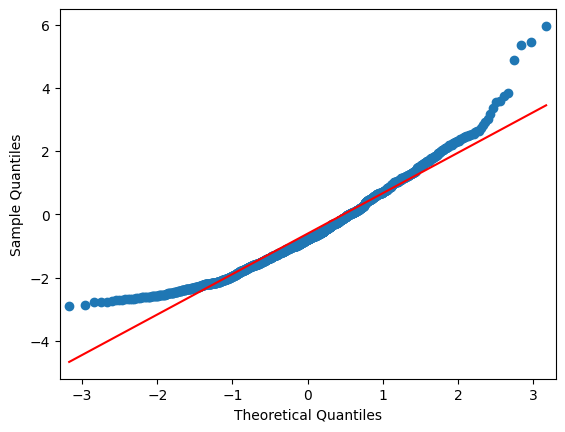

In [231]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

Biểu đồ qqplot cho thấy phần dư chuẩn hóa khá khớp với phân phối chuẩn.

Như vậy, mô hình là hợp lý với dữ liệu.


**Các điểm Infuence**

Các điểm influence là các điểm không tuân theo xu hướng chung của các điểm khác trong tập dữ liệu (outlier) và ảnh hưởng nghiêm trọng đến mô hình. Nó là các điểm có phần dư lớn và giá trị đòn bẩy (leverage) lớn.

Vì các điểm này không thể hiện xu hướng chung của dữ liệu, nó gây nhiễu cho mô hình. Mục tiêu của ta làm tìm các điểm này và loại nó khỏi dữ liệu train, sau đó fit lại để có mô hình tốt hơn.

Các điểm Influence được đánh giá qua giá trị Cook's distance. Ta lấy thử ra 10 điểm có Cook's distance lớn nhất.

In [232]:
infl = fitted_glm.get_influence()

summ_df = infl.summary_frame()

outlier_df = summ_df[["cooks_d", "standard_resid", "hat_diag", "dffits_internal"]].sort_values("cooks_d", ascending=False)[:10]
outlier_df

# cook_df = summ_df[["cooks_d", "standard_resid", "hat_diag", "dffits_internal"]].sort_values("cooks_d", ascending=False)
# cut_off = 4/len(dat_train)
# outlier = cook_df[cook_df["cooks_d"]>cut_off].index.values.tolist()
# len(outlier) # 109

,cooks_d,standard_resid,hat_diag,dffits_internal
2362,6.590678,13.807549,0.453455,11.624897
1273,3.006976,14.305334,0.260711,7.929084
2146,2.681389,12.504587,0.291564,7.558555
263,2.593811,10.755578,0.349857,7.475134
1491,1.731031,7.539944,0.422222,6.168259
620,1.013312,1.576456,0.907284,4.896415
2354,0.813158,6.206179,0.336291,4.242245
1583,0.798149,6.606571,0.305014,4.130770
951,0.181907,3.978634,0.216177,1.974342
2364,0.171004,3.391154,0.263015,1.943432


Quan sát chi tiết 10 điểm có giá trị Cooks_d lớn nhất:

In [233]:
outlier = outlier_df.index.values.tolist()
dat_train.loc[outlier]

,wrkstat,educ_center,polviews,advfront,harass5,snapchat,instagrm,emailmintotal_center
2362,Working parttime,0.611111,Moderate,Not give,Yes,Not give,Not give,1.001
1273,Retired,0.333333,Moderate,Strongly agree,Not give,Yes,No,0.481
2146,Retired,0.666667,Slghtly conservative,Disagree,Not give,Not give,Not give,0.721
263,"Unempl, laid off",0.611111,Liberal,Agree,Not give,Not give,Not give,0.751
1491,Other,0.666667,Conservative,Agree,Not give,Not give,Not give,0.501
620,Working parttime,0.555556,Conservative,Not give,Not give,No,No,0.006
2354,Temp not working,0.777778,Conservative,Agree,Not give,Not give,Not give,0.601
1583,Keeping house,0.777778,Not give,Not give,No,No,No,0.601
951,Keeping house,0.555556,Not give,Disagree,Not give,Not give,Not give,0.351
2364,Other,0.388889,Conservative,Disagree,Not give,Not give,Not give,0.201


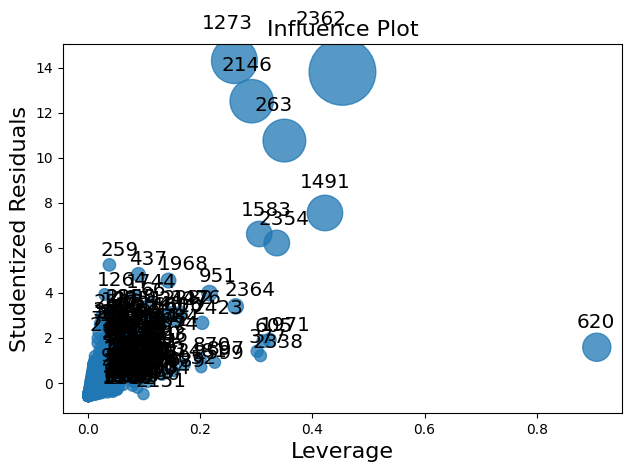

In [234]:
fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

Ta loại bỏ các quan sát có Cook's lớn nhất này và fit lại mô hình, quan sát lại các thông tin đánh giá về residual và phân phối của nó

In [235]:
# dat_train.drop([1583, 2146, 263, 2362], inplace=True)

dat_train.drop(outlier, inplace=True)

In [236]:
fitted_glm = NULL
fitted_glm = smf.glm(formula='emailmintotal_center ~ wrkstat + educ_center + polviews + advfront + harass5', \
                     data=dat_train, \
                     family=sm.families.Gamma(link=sm.families.links.Log())).fit()

fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1308
Model:                              GLM   Df Residuals:                     1284
Model Family:                     Gamma   Df Model:                           23
Link Function:                      Log   Scale:                          2.0117
Method:                            IRLS   Log-Likelihood:                 2619.1
Date:                  Mon, 14 Aug 2023   Deviance:                       2487.8
Time:                          18:15:51   Pearson chi2:                 2.58e+03
No. Iterations:                      20   Pseudo R-squ. (CS):             0.1934
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.7617      1.500     -1.174      0.240      -4.702       1.178
wrkstat[T.Other]                    -0.1906      0.314     -0.607      0.544      -0.806       0.425
wrkstat[T.Retired]                   0.1233      0.163      0.756      0.449      -0.196       0.443
wrkstat[T.School]                    0.2849      0.259      1.100      0.271      -0.223       0.792
wrkstat[T.Temp not working]          0.3872      0.292      1.327      0.184      -0.185       0.959
wrkstat[T.Unempl, laid off]          0.6700      0.239      2.798      0.005       0.201       1.139
wrkstat[T.Working fulltime]          1.2741      0.145      8.806      0.000       0.991       1.558
wrkstat[T.Working parttime]          0.4797      0.173      2.779      0.005       0.141       0.818
polviews[T.Extremely liberal]       -0.0159      0.205     -0.078      0.938      -0.419       0.387
polviews[T.Extrmly conservative]    -0.2184      0.229     -0.953      0.341      -0.668       0.231
polviews[T.Liberal]                 -0.1251      0.152     -0.823      0.410      -0.423       0.173
polviews[T.Moderate]                 0.1067      0.124      0.858      0.391      -0.137       0.351
polviews[T.Not give]                 0.3202      0.244      1.310      0.190      -0.159       0.799
polviews[T.Slghtly conservative]    -0.0527      0.149     -0.354      0.724      -0.345       0.240
polviews[T.Slightly liberal]         0.1887      0.159      1.188      0.235      -0.123       0.500
advfront[T.Disagree]                -0.0255      0.145     -0.175      0.861      -0.310       0.259
advfront[T.Dont know]               -0.3189      0.420     -0.759      0.448      -1.142       0.504
advfront[T.Not give]                -4.2199      1.432     -2.947      0.003      -7.027      -1.413
advfront[T.Strongly agree]           0.0245      0.107      0.230      0.818      -0.184       0.233
advfront[T.Strongly disagree]        0.8809      0.433      2.032      0.042       0.031       1.730
harass5[T.No]                        0.8106      0.395      2.050      0.040       0.035       1.586
harass5[T.Not give]                 -3.3327      1.479     -2.254      0.024      -6.231      -0.434
harass5[T.Yes]                       0.5813      0.444      1.311      0.190      -0.288       1.451
educ_center                          2.0672      0.274      7.549      0.000       1.530       2.604
====================================================================================================
"""

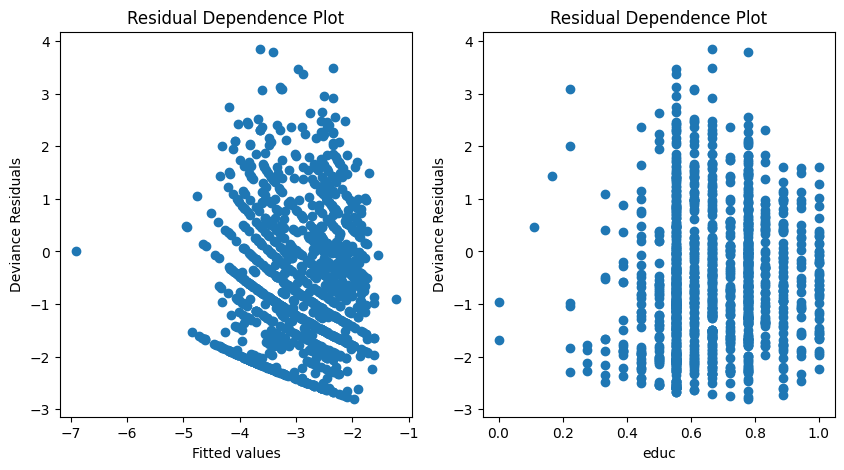

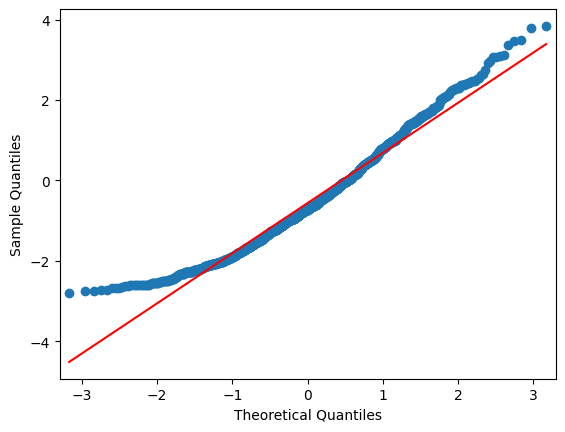

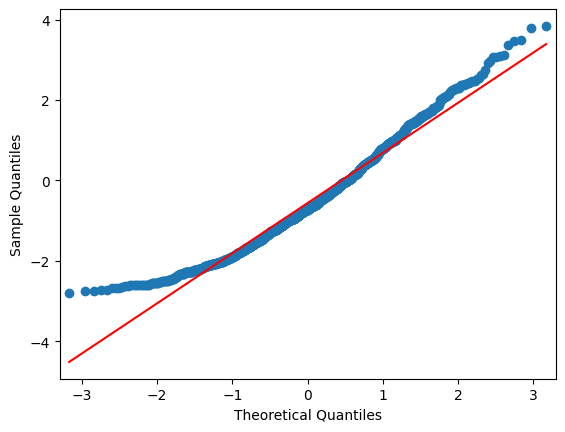

In [237]:
resid = fitted_glm.resid_deviance

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(np.log(fitted_glm.mu), resid)
# ax[0].hlines(0, 0, 1)
ax[0].set_title('Residual Dependence Plot')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_xlabel('Fitted values')

X_train = dat_train.drop(["emailmintotal_center"], axis=1)
ax[1].scatter(X_train['educ_center'], resid)
# ax[1].hlines(0, 0, 1)
ax[1].set_title('Residual Dependence Plot')
ax[1].set_ylabel('Deviance Residuals')
ax[1].set_xlabel('educ')
plt.show()

from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

Như vậy, sau khi loại bỏ chỉ 10 điểm outlier, mô hình có $R^2$ tăng gần 78%, từ 0.1086 lên 0.1934. Các biểu đồ phần dư cũng cho thấy kết quả đẹp hơn so với mô hình trên tập dữ liệu ban đầu.

# 3. Mô hình GAM

Mô hình hồi quy cộng tính tổng quát (GAM - Generalized Additive Models) là trường hợp tổng quát hơn của GLM. GAM cố gắng mô hình hóa cả tác động của các biến độc lập mà có quan hệ phi tuyến với biến phụ thuộc.

Công thức tổng quát của GAM:

$g(\mu) =  \sum_{k} \alpha_k X_k + \sum_{j} s_j(Z_j)$

Trong đó:

- $\mu=E(Y)$ với $Y$ là biến phụ thuộc có phân phối họ mũ
- $X_k$ là các biến độc lập có tác động tuyến tính đến biến phụ thuộc, các hệ số $\alpha_k$ chưa biết.
- $Z_j$ là các biến độc lập có tác động phi tuyến đến biến phụ thuộc, $s_j(.)$ là hàm trơn (spline)
- $g(.)$ là link function

GAM được ước lượng bằng phương pháp hợp lý cực đại có phạt, trong đó các hàm trơn được ước lượng qua các spline và nút.

Đầu tiên ta thử fit mô hình với tất cả các biến mà GLM đã chọn ở trên. Các tham số của GAM cần chọn:
- degree: bậc của hàm trong 1 đoạn spline
- df (degree of freedom): số bậc tự do của spline
- alpha: hệ số phạt


In [238]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=8, degree=3)
alpha = 10

gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                             data=dat_train, smoother=bs, alpha=alpha, \
                             family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
fitted_gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     emailmintotal_center   No. Observations:                 1308
Model:                           GLMGam   Df Residuals:                  1284.15
Model Family:                     Gamma   Df Model:                        22.85
Link Function:                      Log   Scale:                          2.0103
Method:                           PIRLS   Log-Likelihood:                 2619.4
Date:                  Mon, 14 Aug 2023   Deviance:                       2487.2
Time:                          18:15:52   Pearson chi2:                 2.58e+03
No. Iterations:                      14   Pseudo R-squ. (CS):             0.1937
Covariance Type:              nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.7801      1.501     -1.186      0.236      -4.723       1.163
wrkstat[T.Other]                    -0.1911      0.314     -0.609      0.543      -0.806       0.424
wrkstat[T.Retired]                   0.1233      0.163      0.756      0.449      -0.196       0.443
wrkstat[T.School]                    0.2846      0.259      1.100      0.272      -0.223       0.792
wrkstat[T.Temp not working]          0.3884      0.292      1.332      0.183      -0.183       0.960
wrkstat[T.Unempl, laid off]          0.6700      0.239      2.799      0.005       0.201       1.139
wrkstat[T.Working fulltime]          1.2743      0.145      8.810      0.000       0.991       1.558
wrkstat[T.Working parttime]          0.4804      0.173      2.784      0.005       0.142       0.819
polviews[T.Extremely liberal]       -0.0158      0.205     -0.077      0.939      -0.418       0.387
polviews[T.Extrmly conservative]    -0.2191      0.229     -0.956      0.339      -0.668       0.230
polviews[T.Liberal]                 -0.1247      0.152     -0.821      0.412      -0.423       0.173
polviews[T.Moderate]                 0.1062      0.124      0.854      0.393      -0.138       0.350
polviews[T.Not give]                 0.3199      0.244      1.310      0.190      -0.159       0.799
polviews[T.Slghtly conservative]    -0.0529      0.149     -0.355      0.723      -0.345       0.239
polviews[T.Slightly liberal]         0.1881      0.159      1.185      0.236      -0.123       0.499
advfront[T.Disagree]                -0.0243      0.145     -0.168      0.867      -0.309       0.260
advfront[T.Dont know]               -0.3206      0.420     -0.764      0.445      -1.143       0.502
advfront[T.Not give]                -4.2203      1.431     -2.948      0.003      -7.026      -1.415
advfront[T.Strongly agree]           0.0245      0.106      0.230      0.818      -0.184       0.233
advfront[T.Strongly disagree]        0.8828      0.433      2.037      0.042       0.033       1.732
harass5[T.No]                        0.8102      0.395      2.049      0.040       0.035       1.585
harass5[T.Not give]                 -3.3336      1.478     -2.255      0.024      -6.231      -0.436
harass5[T.Yes]                       0.5818      0.443      1.312      0.189      -0.287       1.451
educ_center_s0                       0.3893      0.067      5.781      0.000       0.257       0.521
educ_center_s1                       0.8188      0.133      6.162      0.000       0.558       1.079
educ_center_s2                       1.3230      0.191      6.911      0.000       0.948       1.698
educ_center_s3                       1.4762      0.209      7.048      0.000       1.066       1.887
educ_center_s4                 

Tiếp theo ta fit mô hình với df lớn hơn để tăng tính linh động của spline

In [239]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=90, degree=3)
alpha = 10

gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                             data=dat_train, smoother=bs, alpha=alpha, \
                             family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
# fitted_gam.summary()
print('Pseudo R-squared: ', fitted_gam.pseudo_rsquared())

Pseudo R-squared:  0.20678169521026035


Cố định các tham số degree, df, dùng grid search để chọn alpha tối ưu thông qua tính toán AIC, BIC.

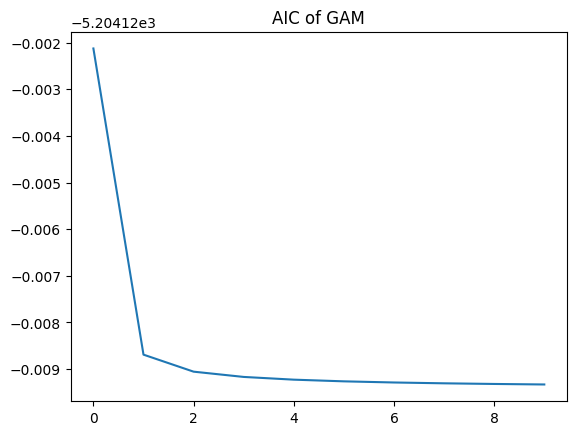

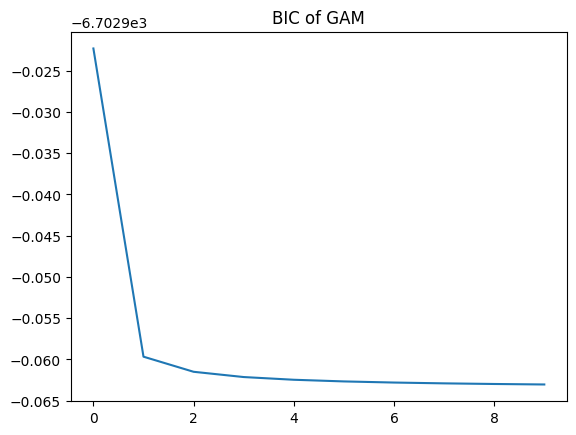

In [240]:
aic_gam = []
bic_gam = []

al = [0.001, 0.01, 0.1, 1]
al = range(1, 100, 10)
# al = range(20)

for i in range(len(al)):
    x_spline = dat_train["educ_center"]
    bs = BSplines(x_spline, df=200, degree=3)

    gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                                 data=dat_train, smoother=bs, alpha=al[i], \
                                 family=sm.families.Gamma(link=sm.families.links.Log()))

    fitted_gam = gam_bs.fit()

    aic_gam.append(fitted_gam.aic)
    bic_gam.append(fitted_gam.bic)

plt.plot(range(len(aic_gam)), aic_gam)
plt.title("AIC of GAM")
plt.show()

plt.plot(range(len(bic_gam)), bic_gam)
plt.title("BIC of GAM")
plt.show()

Như vậy, trường hợp này, alpha tối ưu bằng 100. Ta fit lại mô hình GAM để xem kết quả

In [241]:
x_spline = dat_train["educ_center"]
bs = BSplines(x_spline, df=200, degree=3)

# gam_bs = GLMGam.from_formula(formula = 'emailmintotal ~ wrkstat + polviews + advfront + harass5', \
gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                                data=dat_train, smoother=bs, alpha=100, \
                                family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
# fitted_gam.summary()
fitted_gam.pseudo_rsquared()


0.21208397757960407

Có thể thấy, so với GML thì trong trường hợp này GAM cho kết quả $R^2$ cải thiện gần 8%.

# 4. So sánh kết quả 2 mô hình

Từ đầu đến giờ, ta đều xem xét Pseudo-$R^2$ khi fit mô hình. Đến đây, để tiện so sánh với các mô hình khác nữa, ta sẽ dùng **Cross Validation để tính $R^2$ của GLM bằng thư viện sklearn** (cross_val_score chưa hỗ trợ GAM do cách predict của GAM có thêm tham số cho spline).

Sau đó, để so sánh GLM và GAM ta sẽ dùng **Cross Validation** để cùng chia tập dữ liệu gốc thành tập train/test theo các cách khác nhau, ghi lại kết quả và so sánh trung bình các thông số đánh giá của 2 mô hình như RMSE, **Pseudo-$R^2$**. Kêt quả phần này sẽ không tốt bằng phần xây dựng mô hình phía trên do chỉ để so sánh 2 mô hình nên ta không xử lý các outlier.

In [242]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline


class StatsModelsEstimator(BaseEstimator, RegressorMixin):

    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
        self.family = sm.families.Gamma(link=sm.families.links.Log())

    def fit(self, X, y, **fit_params):
        if fit_params['model'] == 'glm':
            self.model = self.model_class.from_formula(formula=self.formula, data=X, family=self.family)
            self.results_ = self.model.fit()
        elif fit_params['model'] == 'gam':
            x_spline = X["educ_center"]
            bs = BSplines(x_spline, df=200, degree=3)
            alpha = 100
            self.model = self.model_class.from_formula(formula=self.formula, data=X, family=self.family, smoother=bs, alpha=alpha)
            self.results_ = self.model.fit()
        else:
            self.model = self.model_class.from_formula(formula=self.formula, data=X, family=self.family)
            self.results_ = self.model.fit_regularized(method='elastic_net', alpha=0.04,start_params=None, refit=False, opt_method='bfgs')


    def predict(self, X, **predict_params):
        return self.results_.predict(exog = X, **predict_params)

glm = StatsModelsEstimator(sm.GLM, formula_str)
kfold = KFold(n_splits=5)
r2 = cross_val_score(glm, dat_train, dat_train['emailmintotal_center'], cv=kfold, scoring='r2', fit_params={'model':'glm'})
rsme = cross_val_score(glm, dat_train, dat_train['emailmintotal_center'], cv=kfold, scoring='neg_root_mean_squared_error', fit_params={'model':'glm'})
msg = "R2: %f (std %f)" % (r2.mean(), r2.std())

print('R2 and Cross Validation by sklearn:')
print('GLM:')
print(msg)
msg = "RMSE: %f (std %f)" % (-rsme.mean(), rsme.std())
print(msg)

# elastic = StatsModelsEstimator(sm.GLM, formula_str)
# kfold = KFold(n_splits=5)
# r2 = cross_val_score(elastic, dat_train, dat_train['emailmintotal_center'], cv=kfold, scoring='r2', fit_params={'model':'g'})
# rsme = cross_val_score(elastic, dat_train, dat_train['emailmintotal_center'], cv=kfold, scoring='neg_root_mean_squared_error', fit_params={'model':'g'})
# msg = "R2: %f (std %f)" % (r2.mean(), r2.std())

# print('Elastic:')
# print(msg)
# msg = "RMSE: %f (std %f)" % (-rsme.mean(), rsme.std())
# print(msg)

R2 and Cross Validation by sklearn:
GLM:
R2: 0.100042 (std 0.027557)
RMSE: 0.097933 (std 0.003906)


In [243]:
from sklearn.metrics import r2_score, mean_squared_error

def gam_fit(dat_train, dat_test):

    x_spline = dat_train["educ_center"]
    bs = BSplines(x_spline, df=200, degree=3)

    gam_bs = GLMGam.from_formula(formula = 'emailmintotal_center ~ wrkstat + polviews + advfront + harass5', \
                                    data=dat_train, smoother=bs, alpha=100, \
                                    family=sm.families.Gamma(link=sm.families.links.Log()))

    fitted_gam = gam_bs.fit()
    r2 = fitted_gam.pseudo_rsquared()

    X_test = dat_test[["wrkstat", "educ_center", "polviews", "advfront", "harass5"]]
    y_test = dat_test['emailmintotal_center']

    y_hat = fitted_gam.predict(X_test[["wrkstat", "polviews", "advfront", "harass5"]], exog_smooth=X_test[["educ_center"]])
    er = rmse(y_hat, np.array(y_test).flatten())

    return r2, er


def glm_fit(dat_train, dat_test):

    fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
    r2 = fitted_glm.pseudo_rsquared()

    X_test = dat_test[["wrkstat", "educ_center", "polviews", "advfront", "harass5"]]
    y_test = dat_test['emailmintotal_center']

    yhat = fitted_glm.predict(X_test)
    er = rmse(yhat, np.array(y_test).flatten())

    return r2, er

kfold = KFold(n_splits=5)
train = []
test = []
for i, (train_index, test_index) in enumerate(kfold.split(dat)):
    train.append(train_index)
    test.append(test_index)

glm_p_r2 = []
gam_p_r2 = []

glm_rmse = []
gam_rmse = []

for i in range(5):
    dat_train = dat.iloc[list(train[i])]
    dat_test = dat.iloc[list(test[i])]

    gam_p_r2_, gam_rmse_ = gam_fit(dat_train, dat_test)
    gam_p_r2.append(gam_p_r2_)
    gam_rmse.append(gam_rmse_)

    glm_p_r2_, glm_rmse_ = glm_fit(dat_train, dat_test)
    glm_p_r2.append(glm_p_r2_)
    glm_rmse.append(glm_rmse_)

print('GLM vs GAM:')
print('Pseudo R2 of GLM: {0:.4f}'.format(sum(glm_p_r2)/len(glm_p_r2)))
print('Pseudo R2 of GAM: {0:.4f}'.format(sum(gam_p_r2)/len(gam_p_r2)))
print('RMSE of GLM: {0:.4f}'.format(sum(glm_rmse)/len(glm_rmse)))
print('RMSE of GAM: {0:.4f}'.format(sum(gam_rmse)/len(gam_rmse)))

GLM vs GAM:
Pseudo R2 of GLM: 0.1170
Pseudo R2 of GAM: 0.1381
RMSE of GLM: 0.1089
RMSE of GAM: 0.1089


# 5. Kết luận

Như vậy, so sánh giữa GLM và GAM cho bài toán này thì GAM có vẻ cho kết quả tốt hơn 1 chút. Điều này hợp với lý thuyết vì GAM tổng quát hơn nên nó fit được dữ liệu phức tạp hơn.

Tuy nhiên, cả 2 mô hình đều cho $R^2$ khá thấp. Vì sao $R^2$ thấp:
- Đây là bài toán dự đoán thời gian dùng email, nhưng trong dữ liệu chỉ có 1 biến giải thích duy nhất là biến lượng (educ), còn lại đều là biến categorical. Biến educ này cũng không có quan hệ tuyến tính hay quan hệ đơn giản với biến phụ thuộc (thời gian dùng email).
- Dữ liệu phân tán. Nếu dùng ngưỡng xác định outlier thông thường với Cook's distance là 4/n (n là số dòng của tập dữ liệu train) thì có tới 110/1318 mẫu được xác định là outlier (chiếm 8,4%). Chúng em đã thử loại bỏ toàn bộ 111 mẫu này khỏi tập dữ liệu và train lại mô hình thì $R^2$ đạt cỡ trên 36% (khoảng gấp 3 lần $R^2$ nếu dùng cùng mô hình trên tập dữ liệu chưa loại outlier). Tuy nhiên, để đảm bảo tập dữ liệu gốc, chúng em chỉ loại 10 điểm có Cook's distance lớn nhất thì thấy $R^2$ đã tăng gần 80%.
- Tập dữ liệu tuy không nhỏ nhưng nhiều dòng chứa giá trị NaN.
- Liên quan tới thời gian dùng email của 1 người thì có thể có những thông tin quan trọng hơn mà tập dữ liệu này không cung cấp. Ví dụ cùng là làm việc fulltime nhưng với từng nghề nghiệp cụ thể, như công nhân so với nhân viên văn phòng sẽ có mức dùng email rất khác nhau...